In [89]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc

In [90]:
try:
    project_root = Path.cwd().parent
    processed_path = project_root / "data" / "processed"
    
    df_full = pd.read_csv(processed_path / "features_clasificacion.csv")
    df_reduced = pd.read_csv(processed_path / "features_reducido_clasificacion.csv")
    
    print("Datasets cargados exitosamente.")
    print(f"Forma del dataset completo: {df_full.shape}")
    print(f"Forma del dataset reducido: {df_reduced.shape}")

except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. Verifica la ruta: {e}")
    df_full = None
    df_reduced = None


Datasets cargados exitosamente.
Forma del dataset completo: (30000, 36)
Forma del dataset reducido: (30000, 12)


In [91]:
def train_and_evaluate_model(X, y, model, model_name, dataset_name):
    """
    Entrena y evalúa un modelo de clasificación, manejando el desbalance de clases.
    
    Args:
        X (pd.DataFrame): Características.
        y (pd.Series): Variable objetivo.
        model: Instancia del modelo de scikit-learn.
        model_name (str): Nombre del modelo para reportes.
        dataset_name (str): Nombre del dataset para reportes.
        
    Returns:
        dict: Un diccionario con las métricas de evaluación.
    """
    # 3.1. División de datos (estratificada para mantener la proporción de clases)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3.2. Balanceo de Clases (SMOTE) - Solo en el conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # 3.3. Escalado de Características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)
    
    # 3.4. Entrenamiento del Modelo
    model.fit(X_train_scaled, y_train_res)
    
    # 3.5. Predicción y Evaluación
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # 3.6. Recopilación de Métricas
    metrics = {
        'Model': model_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'F1-Score (Default)': f1_score(y_test, y_pred, pos_label=1)
    }
    
    print(f"\n--- Resultados para {model_name} en {dataset_name} ---")
    print(classification_report(y_test, y_pred, target_names=['No Incumplimiento', 'Incumplimiento']))
    
    return metrics


In [92]:
if df_full is not None and df_reduced is not None:
    # CORRECCIÓN: Asegurarse de que solo se usan columnas numéricas para el modelado.
    # Se seleccionan solo los dtypes numéricos y se eliminan las columnas que no son características.
    X_full = df_full.select_dtypes(include=np.number).drop(columns=['default_payment_next_month', 'ID'], errors='ignore')
    y_full = df_full['default_payment_next_month']
    
    X_reduced = df_reduced.select_dtypes(include=np.number).drop(columns=['default_payment_next_month'], errors='ignore')
    y_reduced = df_reduced['default_payment_next_month']

    datasets = {
        "Completo": (X_full, y_full),
        "Reducido": (X_reduced, y_reduced)
    }
    
    # Definir los modelos a probar
    models = {
        "Regresión Logística": LogisticRegression(random_state=42, max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }
    
    results = []
    
    # Iterar sobre cada dataset y cada modelo
    for d_name, (X_data, y_data) in datasets.items():
        for m_name, model_instance in models.items():
            metrics = train_and_evaluate_model(X_data, y_data, model_instance, m_name, d_name)
            results.append(metrics)
            
    # 4.1. Tabla Comparativa de Resultados
    results_df = pd.DataFrame(results).sort_values(by='F1-Score (Default)', ascending=False)
    
    print("\n--- Tabla Comparativa de Rendimiento de Modelos ---")
    display(results_df)


--- Resultados para Regresión Logística en Completo ---
                   precision    recall  f1-score   support

No Incumplimiento       0.86      0.76      0.81      4673
   Incumplimiento       0.40      0.57      0.47      1327

         accuracy                           0.72      6000
        macro avg       0.63      0.66      0.64      6000
     weighted avg       0.76      0.72      0.73      6000


--- Resultados para Random Forest en Completo ---
                   precision    recall  f1-score   support

No Incumplimiento       0.85      0.89      0.87      4673
   Incumplimiento       0.55      0.46      0.50      1327

         accuracy                           0.80      6000
        macro avg       0.70      0.68      0.69      6000
     weighted avg       0.79      0.80      0.79      6000



/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:39:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados para XGBoost en Completo ---
                   precision    recall  f1-score   support

No Incumplimiento       0.85      0.89      0.87      4673
   Incumplimiento       0.53      0.46      0.49      1327

         accuracy                           0.79      6000
        macro avg       0.69      0.67      0.68      6000
     weighted avg       0.78      0.79      0.79      6000


--- Resultados para Regresión Logística en Reducido ---
                   precision    recall  f1-score   support

No Incumplimiento       0.86      0.74      0.79      4673
   Incumplimiento       0.38      0.56      0.45      1327

         accuracy                           0.70      6000
        macro avg       0.62      0.65      0.62      6000
     weighted avg       0.75      0.70      0.72      6000


--- Resultados para Random Forest en Reducido ---
                   precision    recall  f1-score   support

No Incumplimiento       0.85      0.89      0.87      4673
   Incumplimie

/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:39:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados para XGBoost en Reducido ---
                   precision    recall  f1-score   support

No Incumplimiento       0.85      0.90      0.87      4673
   Incumplimiento       0.55      0.46      0.50      1327

         accuracy                           0.80      6000
        macro avg       0.70      0.68      0.69      6000
     weighted avg       0.79      0.80      0.79      6000


--- Tabla Comparativa de Rendimiento de Modelos ---


,Model,Dataset,Accuracy,ROC-AUC,F1-Score (Default)
1,Random Forest,Completo,0.796167,0.750155,0.502239
4,Random Forest,Reducido,0.795500,0.756836,0.501827
5,XGBoost,Reducido,0.798500,0.750075,0.501443
2,XGBoost,Completo,0.792000,0.753097,0.493095
0,Regresión Logística,Completo,0.720000,0.709746,0.472030
3,Regresión Logística,Reducido,0.697167,0.689318,0.450892



--- Análisis Profundo del Mejor Modelo: Random Forest en Dataset Completo ---


/var/folders/4d/tzjl62s93dnc6338903pslc00000gn/T/ipykernel_62043/1433414700.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='mako')


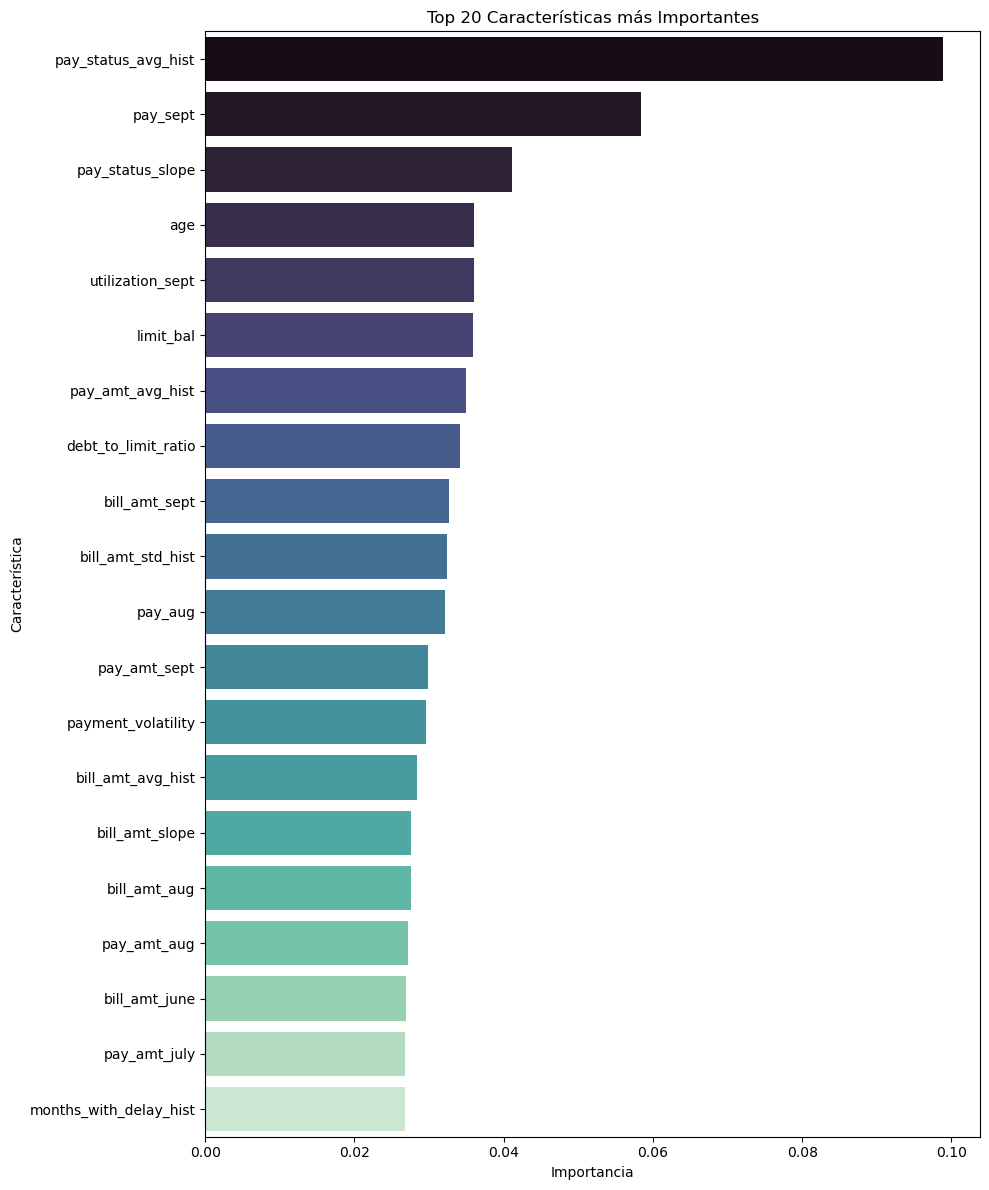

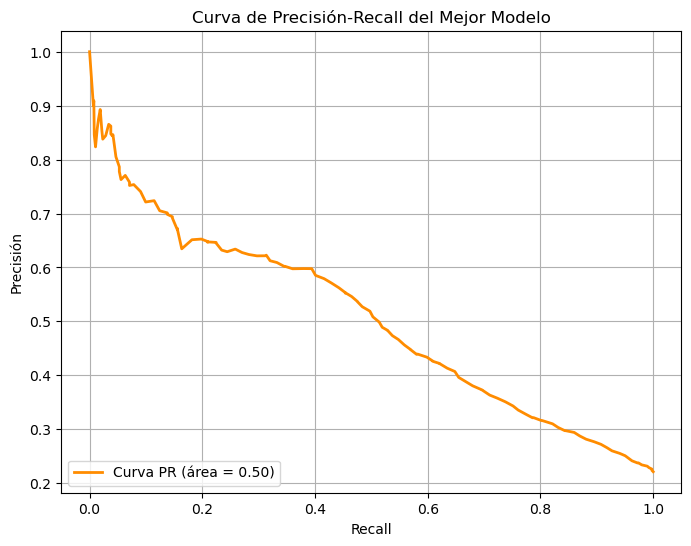

In [93]:
if 'results_df' in locals():
    best_model_name = results_df.iloc[0]['Model']
    best_dataset_name = results_df.iloc[0]['Dataset']
    
    print(f"\n--- Análisis Profundo del Mejor Modelo: {best_model_name} en Dataset {best_dataset_name} ---")
    
    # Re-entrenar el mejor modelo para obtener los artefactos (importancia, curvas)
    X_best, y_best = datasets[best_dataset_name]
    model_best = models[best_model_name]
    
    # Repetir el preprocesamiento
    X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.2, random_state=42, stratify=y_best)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)
    
    model_best.fit(X_train_scaled, y_train_res)
    y_pred_proba_best = model_best.predict_proba(X_test_scaled)[:, 1]
    
    # 5.1. Importancia de Características
    if hasattr(model_best, 'feature_importances_'):
        importances = model_best.feature_importances_
        feature_names = X_best.columns
        
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
        
        plt.figure(figsize=(10, 12))
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='mako')
        plt.title('Top 20 Características más Importantes')
        plt.xlabel('Importancia')
        plt.ylabel('Característica')
        plt.tight_layout()
        plt.show()
        
    # 5.2. Curva de Precisión-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_best)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'Curva PR (área = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title('Curva de Precisión-Recall del Mejor Modelo')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

In [94]:
if 'X_train_scaled' in locals():
    print("\n--- Iniciando Optimización de Hiperparámetros para Random Forest ---")
    
    # 6.1. Definir la parrilla de parámetros para la búsqueda aleatoria
    param_distributions = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    # 6.2. Configurar la Búsqueda Aleatoria
    rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    random_search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_distributions,
        n_iter=50,  # Número de combinaciones a probar
        cv=3,       # Número de validaciones cruzadas
        scoring='f1', # Métrica a optimizar (F1 para la clase positiva por defecto)
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    
    # 6.3. Ejecutar la búsqueda en los datos de entrenamiento
    random_search.fit(X_train_scaled, y_train_res)
    
    # 6.4. Mostrar los mejores parámetros
    print("\n--- Mejores Hiperparámetros Encontrados ---")
    print(random_search.best_params_)
    
    # 6.5. Evaluar el modelo optimizado
    best_rf_clf = random_search.best_estimator_
    y_pred_best_rf = best_rf_clf.predict(X_test_scaled)
    y_pred_proba_best_rf = best_rf_clf.predict_proba(X_test_scaled)[:, 1]
    
    print("\n--- Métricas de Evaluación del Modelo Random Forest OPTIMIZADO ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_best_rf):.4f}")
    print("\nReporte de Clasificación (Optimizado):")
    print(classification_report(y_test, y_pred_best_rf, target_names=['No Incumplimiento', 'Incumplimiento']))


--- Iniciando Optimización de Hiperparámetros para Random Forest ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.5s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.5s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  19.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  19.8s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  19.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  27.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  28.5s
[CV] END max_depth=30, max_feat